<h1>1. Setup and Load Data</h1>

<h2>1.1. Install Dependencies and Setup</h2>

In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OOM error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

<h2>1.2. Load Data</h2>

In [3]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [4]:
data = tf.keras.utils.image_dataset_from_directory('data', class_names=['real', 'fake'], batch_size=16)

Found 140002 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [6]:
batch[0].shape

(16, 256, 256, 3)

<h1>2. Preprocess Data</h1>

<h2>2.1. Scale Data</h2>

In [5]:
data = data.map(lambda x, y: (x / 255, y))

In [6]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].shape

(16, 256, 256, 3)

<h2>2.2. Split the Data</h2>

In [7]:
len(data)

8751

In [8]:
train_size = int(len(data)* .7)
val_size = int(len(data)* .2) 
test_size = int(len(data)* .1) + 1

In [9]:
(val_size + train_size + test_size) == len(data)

True

In [1]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

NameError: name 'data' is not defined

<h1>3. Deep Model</h1>

<h2>3.1. Build deep learning model</h2>

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [12]:
model = Sequential()

In [13]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [16]:
logdir = 'logs'

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
checkpoint_dir = 'training'
checkpoint_path = os.path.join(checkpoint_dir, 'cp.ckpt')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [20]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print('Yes')

Yes


In [21]:
hist = model.fit(train, epochs=30, initial_epoch=27, validation_data=val, callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 28/30
6124/6125 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9737
Epoch 28: saving model to training\cp.ckpt
6125/6125 [==============================] - 348s 56ms/step - loss: 0.0739 - accuracy: 0.9737 - val_loss: 0.0427 - val_accuracy: 0.9861
Epoch 29/30
6124/6125 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9768
Epoch 29: saving model to training\cp.ckpt
6125/6125 [==============================] - 575s 94ms/step - loss: 0.0625 - accuracy: 0.9768 - val_loss: 0.0351 - val_accuracy: 0.9877
Epoch 30/30
6125/6125 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9793
Epoch 30: saving model to training\cp.ckpt
6125/6125 [==============================] - 692s 113ms/step - loss: 0.0578 - accuracy: 0.9793 - val_loss: 0.0338 - val_accuracy: 0.9880


In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 406ms/step


In [25]:
print(f'Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision : 0.9875054359436035, Recall : 0.9865021705627441, Accuracy : 0.9872161149978638


In [26]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

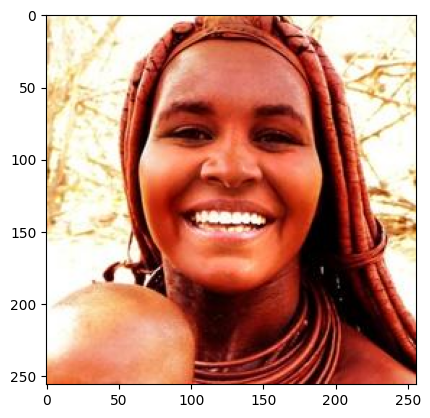

In [27]:
img = cv2.imread('faketest1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

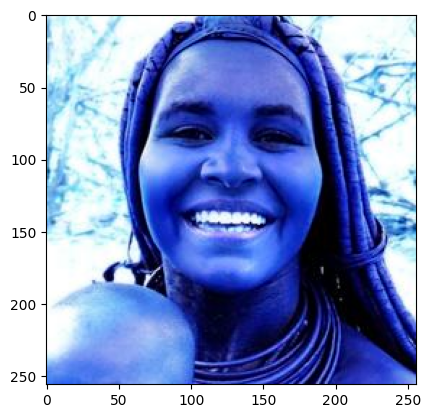

In [28]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 297ms/step


In [30]:
if yhat < 0.5 :
    print('Predicted class is Real.')
else :
    print('Predicted class is Fake.')

Predicted class is Fake.


In [31]:
yhat

array([[1.]], dtype=float32)

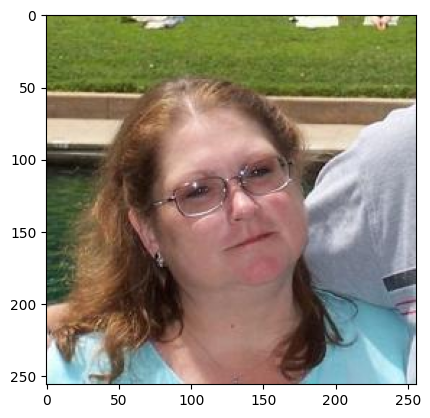

In [32]:
img = cv2.imread('realtest1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

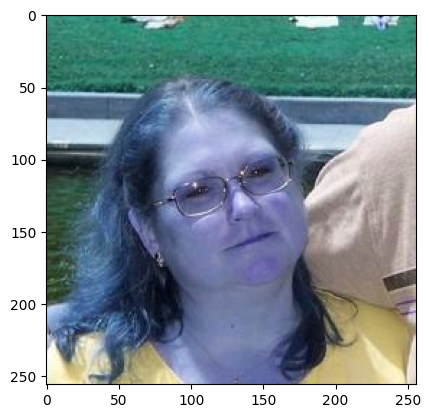

In [33]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [34]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 54ms/step


In [35]:
if yhat < 0.5 :
    print('Predicted class is Real.')
else :
    print('Predicted class is Fake.')

Predicted class is Real.


In [36]:
yhat

array([[0.48369578]], dtype=float32)

In [37]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'deepfake_detection_complete_CNN_model.h5'))